In [1]:
import gc
gc.collect()

73

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
import numpy as np
import skimage.measure
# import pydicom
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.examples.tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras import backend as K
import keras
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input

In [4]:
# plt.gray()
os.chdir('C:/Users/span/Documents/CNN/')

# Adpt From file to Tutorials

In [5]:
# plt.gray()
os.chdir('C:/Users/span/Documents/CNN/')

subfolder1 = "_0255/"
subfolder2 = "_seg3channelfill/"

path1 = "06_origdata/train_image"+subfolder1
path2 = "06_origdata/train_mask"+subfolder2
path3 = "06_origdata/val_image"+subfolder1
path4 = "06_origdata/val_mask"+subfolder2

In [6]:
# https://colab.research.google.com/github/dhassault/tf-semantic-example/blob/master/01b_semantic_segmentation_basic_colab.ipynb#scrollTo=6Vpo8nhYGwy6

def parse_image1(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # For one Image path:
    # .../trainset/images/training/ADE_train_00000001.jpg
    # Its corresponding annotation path is:
    # .../trainset/annotations/training/ADE_train_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "image_0255", "mask_seg3channelfill")
    mask_path = tf.strings.regex_replace(mask_path, "image", "seg", replace_global=False)
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
#     mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

In [7]:
SEED = 1024

train_dataset = tf.data.Dataset.list_files(path1+"image/*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image1)

val_dataset = tf.data.Dataset.list_files(path3+"image/*.png", seed=SEED)
val_dataset =val_dataset.map(parse_image1)

In [8]:
# Here we are using the decorator @tf.function
# if you want to know more about it:
# https://www.tensorflow.org/api_docs/python/tf/function

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 256
# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BATCH_SIZE = 5
BUFFER_SIZE = 1000
TRAIN_LENGTH = len(os.listdir(path1+'image/'))
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

dataset = {"train": train_dataset, "test": val_dataset}

# -- Train Dataset --#
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#-- Validation Dataset --#
test = dataset['test'].map(load_image_test)


In [10]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

# Back to Tutorials

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

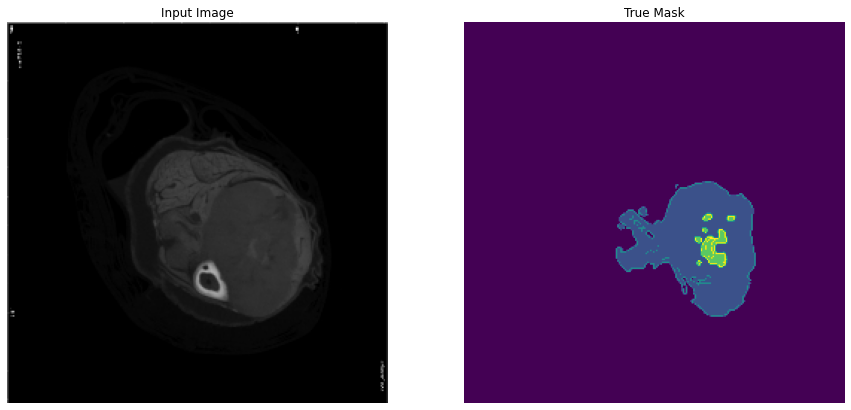

In [12]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [13]:
OUTPUT_CHANNELS = 5

In [14]:
# test 2 GPU
num_gpus = 2
cross_tower_ops = tf.distribute.HierarchicalCopyAllReduce(num_packs=num_gpus)
strategy = tf.distribute.MirroredStrategy(cross_device_ops=cross_tower_ops)
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
    # Use the activations of these layers
    layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]
    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
    down_stack.trainable = False
    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]
    def unet_model(output_channels):
        inputs = tf.keras.layers.Input(shape=[128, 128, 3])
        x = inputs
        skips = down_stack(x)
        x = skips[-1]
        skips = reversed(skips[:-1])
        for up, skip in zip(up_stack, skips):
            x = up(x)
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])
            last = tf.keras.layers.Conv2DTranspose(
                output_channels, 3, strides=2,
                padding='same')  #64x64 -> 128x128
            x = last(x)
            return tf.keras.Model(inputs=inputs, outputs=x)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [15]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

In [16]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
#   inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [34]:
inputs1 = tf.keras.layers.Input(shape=[256, 256, 3])
#   inputs = tf.keras.layers.Input(shape=[128, 128, 3])
x1 = inputs1
skips1 = down_stack(x1)
x2 = skips1[-1]
skips2 = reversed(skips1[:-1])

In [17]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

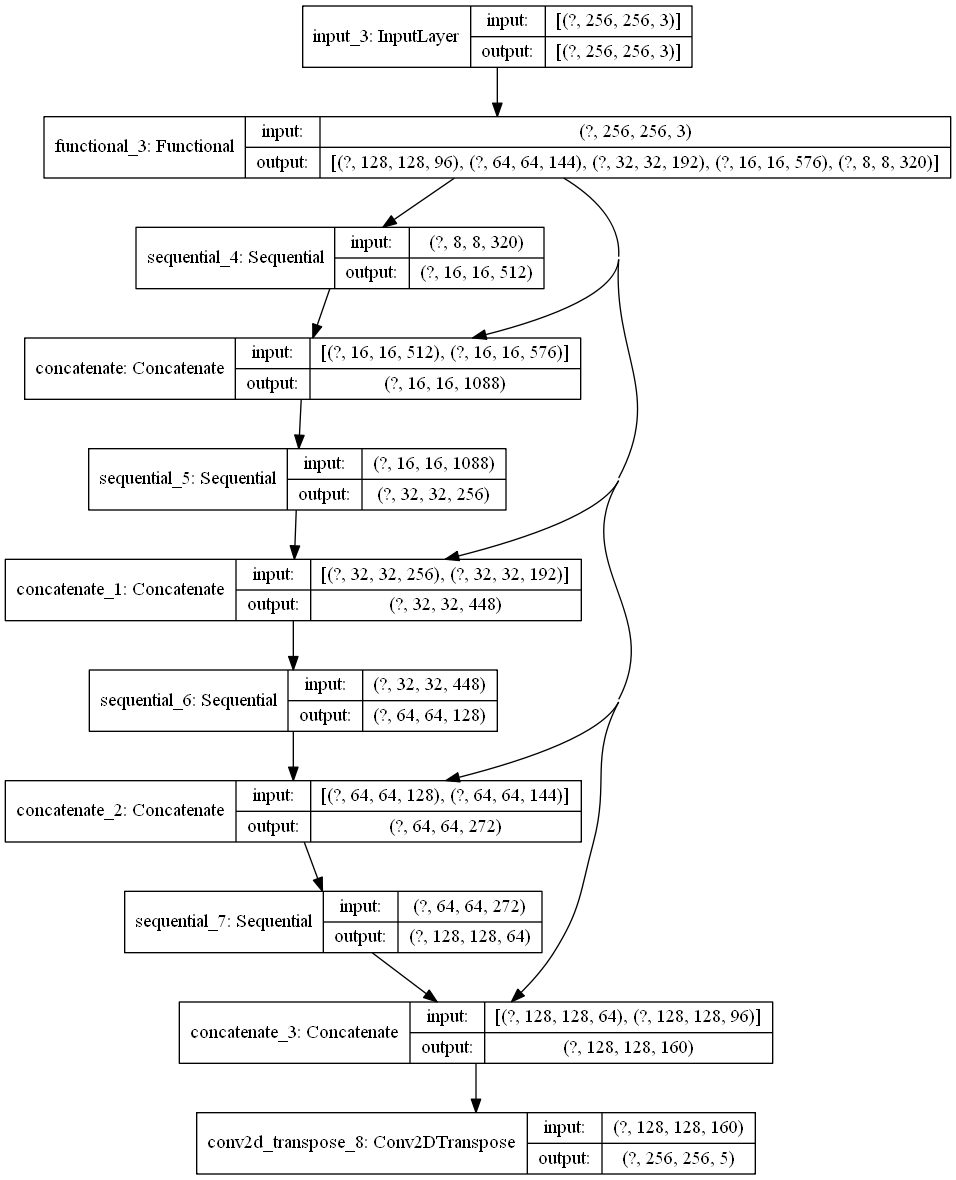

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

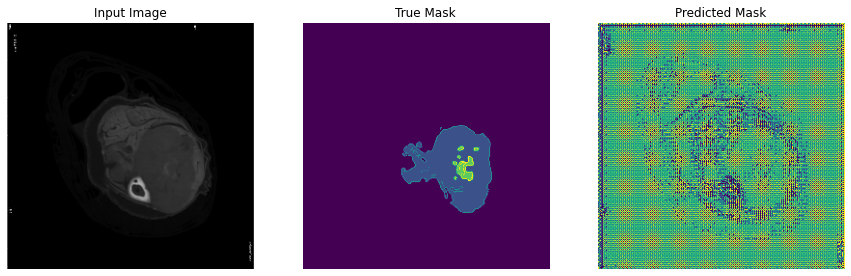

In [21]:
show_predictions()

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [23]:
import tensorboard
from datetime import datetime
# Define the Keras TensorBoard callback.
logdir="tmp/tensorflow_logdir_callback/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# load for continue training
# model = tf.keras.models.load_model('03_model/Model_orig_tensflow.ep20_4sample-5.h5')

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/tmp/saved_model', monitor='accuracy', verbose=3, save_best_only=True, mode='max')

EPOCHS = 50
VAL_SUBSPLITS = 5
NO_OF_VAL_IMAGES = len(os.listdir(path3+'image/'))
VALIDATION_STEPS = NO_OF_VAL_IMAGES//BATCH_SIZE//VAL_SUBSPLITS
# VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[tensorboard_callback]) # ,checkpoint

Epoch 1/50
  1/197 [..............................] - ETA: 0s - loss: 1.4366 - accuracy: 0.3311WARNING:tensorflow:From C:\Users\span\anaconda3\envs\tf-n-gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
197/197 [==============================] - 14s 70ms/step - loss: 0.2130 - accuracy: 0.9386 - val_loss: 0.1404 - val_accuracy: 0.9545
Epoch 2/50
197/197 [==============================] - 12s 60ms/step - loss: 0.1083 - accuracy: 0.9649 - val_loss: 0.0975 - val_accuracy: 0.9675
Epoch 3/50
197/197 [==============================] - 11s 58ms/step - loss: 0.0926 - accuracy: 0.9687 - val_loss: 0.0907 - val_accuracy: 0.9687
Epoch 4/50
197/197 [==============================] - 11s 56ms/step - loss: 0.0827 - accuracy: 0.9712 - val_loss: 0.0894 - val_accuracy: 0.9687
Epoch 5/50
197/197 [=========================

In [28]:
model.save('C:/Users/span/Documents/CNN/tmp/saved_model')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-28-1825d8aecaa6>, line 1)

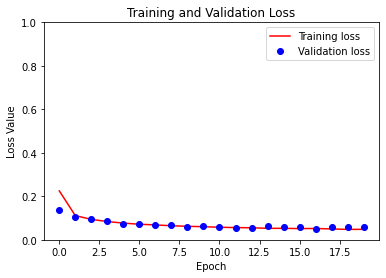

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

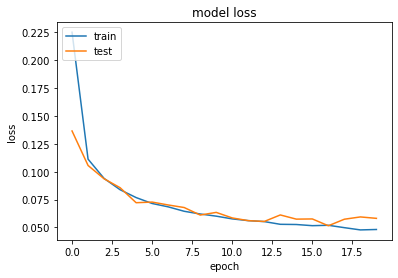

In [23]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

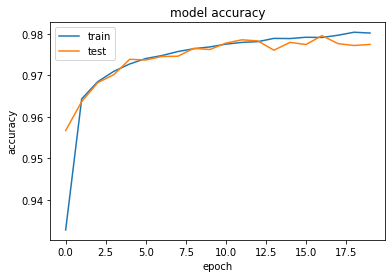

In [24]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

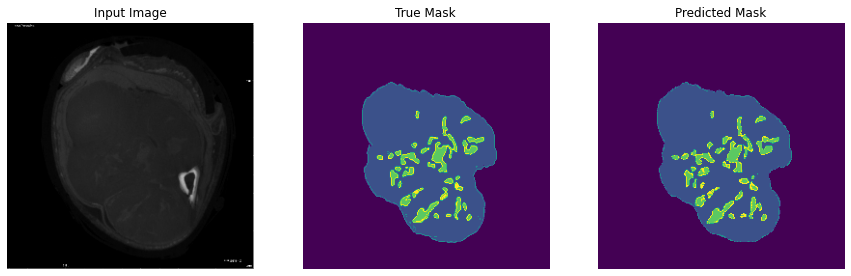

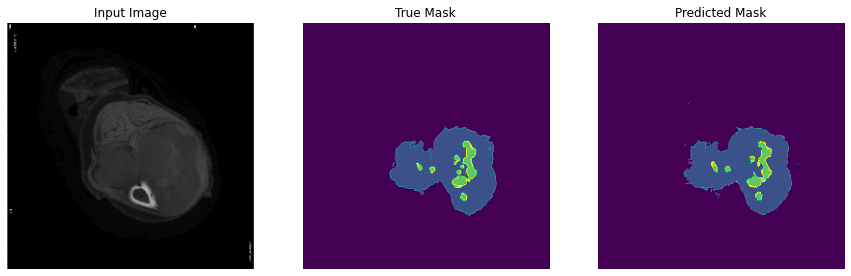

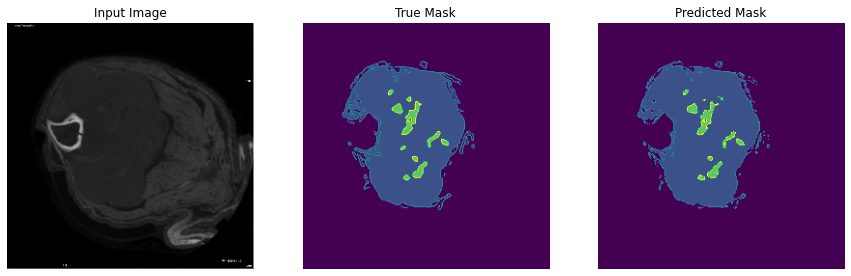

In [29]:
show_predictions(test_dataset, 3)

# Test model

In [30]:
# load model
load_model = tf.keras.models.load_model('/tmp/saved_model')

In [31]:
# load test dataset
SEED = 1024
subfolder1 = "_0255/"
path5 = "06_origdata/test_image"+subfolder1

test_dataset = tf.data.Dataset.list_files(path5+"image/*.png", seed=SEED)
test_dataset = test_dataset.map(parse_image1)

In [32]:
IMG_SIZE = 256

dataset1 = {"test": test_dataset}

test1 = dataset1['test'].map(load_image_test)
test1 = test1.cache().batch(BATCH_SIZE)
test1 = test1.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  

In [33]:
# test loaded model
earlyStopImprove = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)

loss, acc = load_model.evaluate(test1, batch_size=BATCH_SIZE, verbose=2, callbacks=[earlyStopImprove]
                              )
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

30/30 - 7s - loss: 0.0501 - accuracy: 0.8157
Restored model, accuracy: 81.57%


In [ ]:
# Model_orig_tensflow_checkpoint.h5    accuracy: 81.87%
# Model_orig_tensflow.ep20_4sample-5.h5    accuracy: 81.58%
# Model_orig_tensflow.ep20_4sample-4.82.h5    accuracy: 82.92%
# Model_orig_tensflow.ep20_4sample-3.65.h5    accuracy: ~80%
# Model_orig_tensflow.ep20_4sample-2.h5    accuracy: ~80%
# Model_orig_tensflow.ep20_4sample.h5    accuracy: ~81%

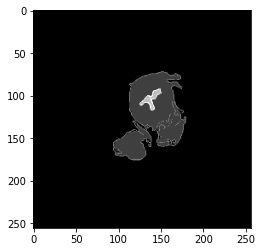

In [11]:
# read image
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

img22 = cv2.imread('C:/Users/span/Documents/CNN/06_origdata/test_mask_seg3channelfill/seg/23_image_026.png')

# C:/Users/span/Documents/CNN/02_data/train_mask_re255/seg
# C:/Users/span/Documents/CNN/02_data/train_mask/23_train_mask/seg/

img22.shape
plt.imshow(tf.keras.preprocessing.image.array_to_img(img22))

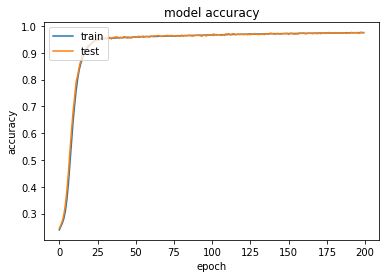

In [50]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# TEST ZONE

# Tutorials

In [ ]:
os.chdir('C:/Users/span/Documents/CNN/date_oxford/')
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

# From generator

In [4]:
subfolder1 = "_0255/"
# subfolder1 = "/"
subfolder2 = "_seg3channelfill/"

path1 = "02_data/train_image"+subfolder1
path2 = "02_data/train_mask"+subfolder2
path3 = "02_data/val_image"+subfolder1
path4 = "02_data/val_mask"+subfolder2

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
#     rescale=1./255
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)
        
val_datagen = ImageDataGenerator(
#     rescale=1./255
                                )

In [6]:
batch_size1 = 16

train_image_generator = train_datagen.flow_from_directory(
    path1,
#     color_mode = "grayscale",
    batch_size = batch_size1 #NORMALLY 4/8/16/32
)

train_mask_generator = train_datagen.flow_from_directory(
    path2,
#     color_mode = "grayscale",
    batch_size = batch_size1 #NORMALLY 4/8/16/32
)

val_image_generator = val_datagen.flow_from_directory(
    path3,
#     color_mode = "grayscale",
    batch_size = batch_size1 #NORMALLY 4/8/16/32
)


val_mask_generator = val_datagen.flow_from_directory(
    path4,
#     color_mode = "grayscale",
    batch_size = batch_size1 #NORMALLY 4/8/16/32
)

Found 472 images belonging to 1 classes.
Found 472 images belonging to 1 classes.
Found 203 images belonging to 1 classes.
Found 203 images belonging to 1 classes.


In [7]:
def my_image_mask_generator(image_data_generator, mask_data_generator):
    train_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in train_generator:
        yield (img, mask)
        
train_generator = my_image_mask_generator(train_image_generator, train_mask_generator)
val_generator = my_image_mask_generator(val_image_generator, val_mask_generator)

In [ ]:
data_root = (“<Copied path>”)
IMAGE_SHAPE = (256, 256)
TRAINING_DATA_DIR = str(data_root)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

In [ ]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset=”validation”,
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset=”training”,
shuffle=True,
target_size=IMAGE_SHAPE)

In [2]:
import tensorflow_datasets as tfds
from tensorflow.examples.tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras import backend as K
import keras
# from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input
import tensorflow as tf

In [ ]:
# https://yann-leguilly.gitlab.io/post/2019-10-09-tensorflow-tfdata/
IMG_DIM = 256

dataset = tf.data.Dataset.from_generator(lambda:train_generator, 
                                        output_types=(tf.float32, tf.int32),
                                         output_shapes=([None, IMG_DIM, IMG_DIM, 3],
                                                        [batch_size1, 3]))
it = iter(dataset)
it.get_next()

In [14]:
# https://stackoverflow.com/questions/45828616/streaming-large-training-and-test-files-into-tensorflows-dnnclassifier/45829855#45829855
datasettra = tf.data.Dataset.from_generator(
        lambda:train_generator, (tf.float32, tf.int32), ((2,), ()))

datasetval = tf.data.Dataset.from_generator(
        lambda:val_generator, (tf.float32, tf.int32), ((2,), ()))

# ?? dataset = tf.data.Dataset.zip(datasettra, datasetval)

In [ ]:
# https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test

# https://stackoverflow.com/questions/49531286/tensorflow-tf-data-dataset-cannot-batch-tensors-with-different-shapes-in-compo
train = dataset.take(int(0.7 * 472)).map(lambda _: it.get_next())
test = dataset.skip(int(0.7 * 472)).map(lambda _: it.get_next())
BUFFER_SIZE = 160
BATCH_SIZE = 16



In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

# From file

In [11]:
# plt.gray()
os.chdir('C:/Users/span/Documents/CNN/')

subfolder1 = "_0255/"
subfolder2 = "_seg3channelfill/"

path1 = "02_data/train_image"+subfolder1
path2 = "02_data/train_mask"+subfolder2
path3 = "02_data/val_image"+subfolder1
path4 = "02_data/val_mask"+subfolder2

In [55]:
# https://colab.research.google.com/github/dhassault/tf-semantic-example/blob/master/01b_semantic_segmentation_basic_colab.ipynb#scrollTo=6Vpo8nhYGwy6

def parse_image1(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # For one Image path:
    # .../trainset/images/training/ADE_train_00000001.jpg
    # Its corresponding annotation path is:
    # .../trainset/annotations/training/ADE_train_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "image_0255", "mask_seg3channelfill")
    mask_path = tf.strings.regex_replace(mask_path, "image", "seg", replace_global=False)
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
#     mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}



In [56]:
SEED = 1024

train_dataset = tf.data.Dataset.list_files(path1+"image/*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image1)

val_dataset = tf.data.Dataset.list_files(path3+"image/*.png", seed=SEED)
val_dataset =val_dataset.map(parse_image1)

In [57]:
# Here we are using the decorator @tf.function
# if you want to know more about it:
# https://www.tensorflow.org/api_docs/python/tf/function

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

#     if tf.random.uniform(()) > 0.5:
#         input_image = tf.image.flip_left_right(input_image)
#         input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [58]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 5
IMG_SIZE = 256
# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])


<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>


In [59]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

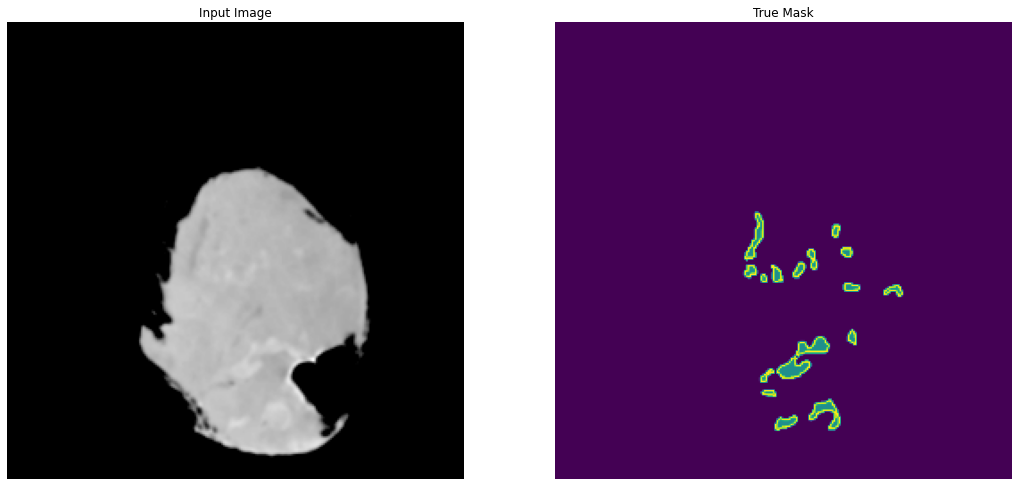

In [60]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
# mutiple GPU (less auc?)

num_gpus = 2
def get_model(optimizer, loss_metric, metrics, lr=1e-3):
    cross_tower_ops = tf.distribute.HierarchicalCopyAllReduce(num_packs=num_gpus)
    strategy = tf.distribute.MirroredStrategy(cross_device_ops=cross_tower_ops)
#     strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        inputs = keras.Input((sample_width, sample_height, 1))
        conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(inputs)
        conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(conv1)
        conv1 = tf.reshape(conv1, tf.shape(conv1))
        pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
        drop1 = keras.layers.Dropout(0.5)(pool1)

        conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(drop1)
        conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(conv2)
        conv2 = tf.reshape(conv2, tf.shape(conv2))
        pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
        drop2 = keras.layers.Dropout(0.5)(pool2)

        conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(drop2)
        conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(conv3)
        conv3 = tf.reshape(conv3, tf.shape(conv3))
        pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
        drop3 = keras.layers.Dropout(0.3)(pool3)

        conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(drop3)
        conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(conv4)
        conv4 = tf.reshape(conv4, tf.shape(conv4))
        pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
        drop4 = keras.layers.Dropout(0.3)(pool4)

        conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='SAME')(drop4)
        conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='SAME')(conv5)
        conv5 = tf.reshape(conv5, tf.shape(conv5))
    
        conv5u = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv5)
        conv5u = tf.reshape(conv5u, tf.shape(conv5u))
        up6 = keras.layers.concatenate([conv5u, conv4], axis=3)
        conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(up6)
        conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='SAME')(conv6)
        conv6 = tf.reshape(conv6, tf.shape(conv6))
    
        conv6u = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv6)
        conv6u = tf.reshape(conv6u, tf.shape(conv6u))
        up7 = keras.layers.concatenate([conv6u, conv3], axis=3)
        conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(up7)
        conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='SAME')(conv7)
        conv7 = tf.reshape(conv7, tf.shape(conv7))
    
        conv7u = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv7)
        conv7u = tf.reshape(conv7u, tf.shape(conv7u))
        up8 = keras.layers.concatenate([conv7u, conv2], axis=3)
        conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(up8)
        conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='SAME')(conv8)
        conv8 = tf.reshape(conv8, tf.shape(conv8))
    
        conv8u = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='SAME')(conv8)
        conv8u = tf.reshape(conv8u, tf.shape(conv8u))
        up9 = keras.layers.concatenate([conv8u, conv1], axis=3)
        conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(up9)
        conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME')(conv9)
        conv9 = tf.reshape(conv9, tf.shape(conv9))

        conv10 = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)
        conv10 = tf.reshape(conv10, tf.shape(conv10))

        model = keras.Model(inputs=[inputs], outputs=[conv10])

        model.compile(optimizer=optimizer(lr=lr), loss=loss_metric, metrics=metrics)
        return model

In [ ]:
smooth = 1.
# Dice Coefficient to work with Tensorflow
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Dice Coefficient to work outside Tensorflow
def dice_coef_2(y_true, y_pred):
    side = len(y_true[0])
    y_true_f = y_true.reshape(side*side)
    y_pred_f = y_pred.reshape(side*side)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)

In [ ]:
sample_width = 256
sample_height = 256

model = get_model(optimizer=tf.keras.optimizers.Adam, loss_metric=dice_coef_loss, metrics=['AUC', dice_coef], lr=1e-6)
# 'AUC'

In [ ]:
# model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# historyTF = model.fit(
#     train_generator, 
#     batch_size=4, 
#     epochs=10, 
#     validation_data = 
#     (val_image_generator,
#      val_mask_generator)
# )

In [ ]:
# fit the keras model on the dataset
# historyKe = model.fit(train_image_generator, train_mask_generator, epochs=150, batch_size=10)

# train_generator = zip(train_image_generator, train_mask_generator)
# val_generator = zip(val_image_generator, val_mask_generator)

# from keras import backend as K

# historyTF = model.fit(train_generator, epochs=10, validation_data=val_generator)


In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=5)

ACCURACY_THRESHOLD = 0.95
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('auc') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

NO_OF_EPOCHS = 300

NO_OF_TRAINING_IMAGES = len(os.listdir('02_data/train_image_0255/image/'))
NO_OF_VAL_IMAGES = len(os.listdir('02_data/val_image_0255/image/'))

# NO_OF_TRAINING_IMAGES = len(os.listdir('02_data/train_image_re255/image/'))
# NO_OF_VAL_IMAGES = len(os.listdir('02_data/val_image_re255/image/'))

BATCH_SIZE = batch_size1

results = model.fit(train_generator, 
                    epochs=NO_OF_EPOCHS, 
                    steps_per_epoch=(NO_OF_TRAINING_IMAGES//BATCH_SIZE), 
                    validation_data=val_generator, 
                    validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE),
                    callbacks=myCallback() #[callback]
                   )

In [ ]:
model.save('03_model/Model_ep200_23.32.h5')

In [ ]:
# !mkdir saved_model
# model.save('03_model/saved_model/my_model_ep100') 

In [ ]:
print(results.history.keys())

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(results.history['auc'])
plt.plot(results.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
from PIL import Image

# img0 = Image.fromarray(val_image_generator[3].astype(np.uint8), mode = "L")

im = Image.new('L', (256, 256))
im.putdata(val_image_generator[5])
plt.imshow(im)

In [ ]:
dataset_as_tuple = next(val_image_generator)

samples_to_predict = np.array(dataset_as_tuple[0])
samples_to_predict2 = (((samples_to_predict - samples_to_predict.min()) / (samples_to_predict.max() - samples_to_predict.min())) * 255.9).astype(np.uint8)
plt.imshow(samples_to_predict2[0,:,:])

In [ ]:
predictions = model.predict(dataset_as_tuple[0])
samples_to_predict3 = np.array(predictions[0])
# samples_to_predict4 = (((samples_to_predict3 - samples_to_predict3.min()) / (samples_to_predict3.max() - samples_to_predict3.min())) * 255.9).astype(np.uint8)
plt.imshow(samples_to_predict3[:,:,0])

In [ ]:
samples_to_predict5 = samples_to_predict3.copy()
samples_to_predict5[samples_to_predict5 >= np.percentile(samples_to_predict5, 95)] = 255
samples_to_predict5[samples_to_predict5 != 255 ] = 0
plt.imshow(samples_to_predict5[:,:,0])

In [ ]:
dataset_as_tuple = next(val_mask_generator)

samples_to_predict = np.array(dataset_as_tuple[0])
samples_to_predict2 = (((samples_to_predict - samples_to_predict.min()) / (samples_to_predict.max() - samples_to_predict.min())) * 255.9).astype(np.uint8)
plt.imshow(samples_to_predict2[0,:,:])

In [ ]:
samples_to_predict4[150,:,0]

In [ ]:
a1 = np.array(dataset_as_tuple[0])[0,:,:]
plt.imshow(a1)

In [ ]:
print(a1.max(),a1.min())